# Training aller Modelle

Alle Modelle wurden ähnlich trainiert. Für alle Trainings wurde eine grosse Epoche gewählt mit dem Hintergedanken das wir die Klasse `EarlyStopping` verwenden.

Die `EarlyStopping`-Methode wird beim Training von Modellen verwendet, um das Training **frühzeitig zu beenden**, wenn sich die Leistung auf dem Validierungsset **nicht mehr verbessert**.  
Dies hilft, **Overfitting zu vermeiden** und **Rechenressourcen zu sparen**.

| Parameter   | Beschreibung |
|-------------|--------------|
| `patience`  | Anzahl der Epochen ohne Verbesserung, bevor das Training gestoppt wird. |
| `min_delta` | Minimale Verbesserung, die als Fortschritt gewertet wird. |
| `mode`      | `'min'` für Verlust (Loss), `'max'` z. B. für Accuracy – gibt an, ob kleiner oder größer besser ist. |

## Warum ist das nützlich?

- Spart Trainingszeit  
- Verhindert Overfitting  
- Fördert bessere Generalisierung

Wir haben zusätzlich die `Lernraten` dynamisch angepasst mit `Lernraten-Scheduler`.

Ein **Lernraten-Scheduler** passt die Lernrate während des Trainings dynamisch an, um:

- die Konvergenz zu beschleunigen,
- die Leistung zu verbessern,
- und Plateaus oder lokale Minima zu überwinden.

Je nach Eintrag in `config["lr_scheduler"]` wird einer der folgenden Scheduler aktiviert:

### `ReduceLROnPlateau`

```python
optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=5,
    min_lr=1e-6
)
```

- Reduziert die Lernrate, wenn sich der Validierungswert (z. B. `val_loss`) nicht verbessert.
- `factor`: Multiplikator für die Lernrate (z. B. halbieren).
- `patience`: Anzahl der Epochen ohne Verbesserung.
- `min_lr`: Untere Schranke für die Lernrate.

### `CosineAnnealingLR`

```python
optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=epochs,
    eta_min=1e-6
)
```

- Wendet einen **kosinusförmigen Abfall** der Lernrate an.
- `T_max`: Maximale Anzahl an Epochen.
- `eta_min`: Minimale Lernrate.

### `StepLR`

```python
optim.lr_scheduler.StepLR(
    optimizer,
    step_size=10,
    gamma=0.5
)
```

- Reduziert die Lernrate alle `step_size` Epochen um den Faktor `gamma`.

## Lernraten-Warmup

Wir haben auch ein **Warmup** aktiviert werden, um die Lernrate zu Beginn des Trainings **schrittweise zu erhöhen**:

```python
optim.lr_scheduler.LinearLR(
    optimizer,
    start_factor=0.1,
    end_factor=1.0,
    total_iters=warmup_epochs
)
```

- `start_factor`: Startwert der Lernrate (Anteil der ursprünglichen LR).
- `end_factor`: Endwert (meist 1.0).
- `total_iters`: Anzahl an Warmup-Epochen.

## Vorteile

- Schnellere und stabilere Konvergenz
- Anpassung an Trainingsverlauf
- Vermeidung von zu großen Lernraten in späteren Trainingsphasen

Für die restlichen anpassungen für das Training wie `Batchsize`, `Kernel Size`, `Hidden Layers`, `CNN Channels`, `dropouts` usw, haben wir einfach (mit dem vorwissen von `del`) die üblichsten verwendet und mehrmals trainiert. Für die Finalen werte wurden alle Modelle zusammen `462`mal mit verschiedenen kombinationen trainiert.


# Was ist ein CNN-Modell und wie funktioniert es? 
 
Ein **Convolutional Neural Network (CNN)** ist ein spezieller Typ von künstlichem neuronalen Netzwerk, der besonders gut für die Verarbeitung von Daten mit einer Gitterstruktur geeignet ist – zum Beispiel Bilder (2D-Gitter) oder Zeitreihen (1D-Gitter). Im Gegensatz zu klassischen vollvernetzten Netzwerken nutzt ein CNN sogenannte Faltungsschichten (Convolutional Layers), die lokale Muster in den Daten erkennen können. Das macht CNNs sehr leistungsfähig für Aufgaben wie Bild- oder Signalverarbeitung.
 
## Unsere Modellarchitektur
 
```python
 class CNN(nn.Module):
     def __init__(self, in_channels, out_channels, kernel_size, num_classes):
         super().__init__()
         self.conv = nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, padding=kernel_size // 2)
         self.pool = nn.AdaptiveAvgPool1d(1)
         self.fc = nn.Linear(out_channels, num_classes)
 
     def forward(self, x):
         x = self.conv(x)
         x = self.pool(x).squeeze(-1)
         x = self.fc(x)
         return x
```
 
**Erklärung der Architektur:**
- Die erste Schicht ist eine 1D-Faltungsschicht (`nn.Conv1d`), die lokale Muster in den Eingabedaten erkennt. Die Parameter `in_channels`, `out_channels` und `kernel_size` bestimmen die Anzahl der Eingangskanäle, die Anzahl der Filter (Feature Maps) und die Größe des Faltungsfensters.
- Danach folgt ein **Adaptive Average Pooling** (`nn.AdaptiveAvgPool1d(1)`), das die Länge der Zeitachse auf 1 reduziert. Dadurch wird aus jedem Feature-Map ein einziger Wert extrahiert, unabhängig von der ursprünglichen Länge der Eingabesequenz.
- Abschließend folgt eine vollverbundene Schicht (`nn.Linear`), die die extrahierten Merkmale auf die gewünschte Anzahl an Klassen abbildet.
 
---
 
## Warum haben wir diese "Tweaks" verwendet?
 
- **Padding (`padding=kernel_size // 2`)**: Durch dieses Padding bleibt die Ausgabelänge nach der Faltung gleich der Eingabelänge ("same padding"). Das erleichtert die Architektur und verhindert, dass Informationen an den Rändern verloren gehen.
- **Adaptive Average Pooling**: Reduziert die Feature-Maps auf eine feste Größe (hier: 1), unabhängig von der Eingabelänge. Das macht das Modell flexibler für unterschiedlich lange Eingabesequenzen.
- **Einfache Architektur**: Die Architektur ist bewusst einfach gehalten, um Überanpassung (Overfitting) zu vermeiden und die wichtigsten Muster in den Daten zu extrahieren, ohne zu komplex zu werden.
- **Hyperparameter-Tuning**: Die Anzahl der Kanäle (`out_channels`) und die Kernelgröße (`kernel_size`) sind Hyperparameter, die wir im Grid Search (siehe z.B. `cnn_channels_list = [16, 32, 64, 128]` und `kernel_sizes = [3, 5, 7, 9]`) variieren, um die beste Modellkonfiguration für unsere Daten zu finden.
- **Batch Size & Learning Rate**: Auch die Batch-Größe und die Lernrate werden im Grid Search getestet, um die Trainingsdynamik optimal einzustellen.
 
Insgesamt sorgen diese Anpassungen dafür, dass das Modell sowohl leistungsfähig als auch robust gegenüber unterschiedlichen Dateneigenschaften ist.

In [1]:
from pathlib import Path
import os
import json
import pandas as pd

notebook_dir = Path().resolve()
project_root = notebook_dir.parent

print(f"Projektpfad: {project_root}")
os.chdir(project_root)

log_dir = Path(project_root) / "logs"

import src.utils as utils

Projektpfad: /home/arian/cdl1/CDL1-MChallenge


In [2]:
cnn_dir = log_dir

json_files = list(cnn_dir.glob("cnn*.json"))

if not json_files:
    print(f"Keine JSON-Dateien im Verzeichnis {cnn_dir} gefunden. Abbruch.")
    
else:

    results = []
    all_data = {}
    for file in json_files:
        with open(file, "r") as f:
            data = json.load(f)
            run_name = file.stem
            results.append({
                "run_name": run_name,
                "val_acc_last": round(data["val_acc"][-1], 3) if data["val_acc"] else None,
                "val_loss_last": round(data["val_loss"][-1], 3) if data["val_loss"] else None,
                "train_loss_last": round(data["train_loss"][-1], 3) if data["train_loss"] else None,
                "test_accuracy": round(data.get("test_metrics", {}).get("test_accuracy", None), 3) if data.get("test_metrics", {}).get("test_accuracy", None) is not None else None,
                "test_f1": round(data.get("test_metrics", {}).get("test_f1", None), 3) if data.get("test_metrics", {}).get("test_f1", None) is not None else None,
            })
            all_data[run_name] = data

    df = pd.DataFrame(results)

    # Only top 6 models by test_f1
    top_n = 6
    top_models = df.sort_values(by="test_f1", ascending=False).head(top_n)
    worst_models = df.sort_values(by="test_f1", ascending=False).tail(3)

    print(f"Top {top_n} Modelle basierend auf Test-F1:")
    print(top_models.to_string(index=False))
    print(f"--------------------------------")
    print(f"Schlechteste 3 Modelle basierend auf Test-F1:")
    print(worst_models.to_string(index=False))
    print(f"--------------------------------")

    models_to_plot = top_models.reset_index(drop=True)

Top 6 Modelle basierend auf Test-F1:
                run_name  val_acc_last  val_loss_last  train_loss_last  test_accuracy  test_f1
 cnn-bs-64-cnn_c-256-k-5         0.920          0.307            0.100          0.939    0.939
  cnn-bs-64-cnn_c-64-k-5         0.926          0.264            0.107          0.935    0.936
cnn-bs-128-cnn_c-128-k-5         0.934          0.267            0.098          0.935    0.936
 cnn-bs-32-cnn_c-128-k-5         0.926          0.292            0.105          0.930    0.930
 cnn-bs-64-cnn_c-128-k-5         0.941          0.262            0.102          0.928    0.929
cnn-bs-128-cnn_c-256-k-5         0.926          0.250            0.100          0.921    0.921
--------------------------------
Schlechteste 3 Modelle basierend auf Test-F1:
               run_name  val_acc_last  val_loss_last  train_loss_last  test_accuracy  test_f1
cnn-bs-32-cnn_c-128-k-3         0.865          0.445            0.491          0.765    0.730
 cnn-bs-32-cnn_c-64-k-3        

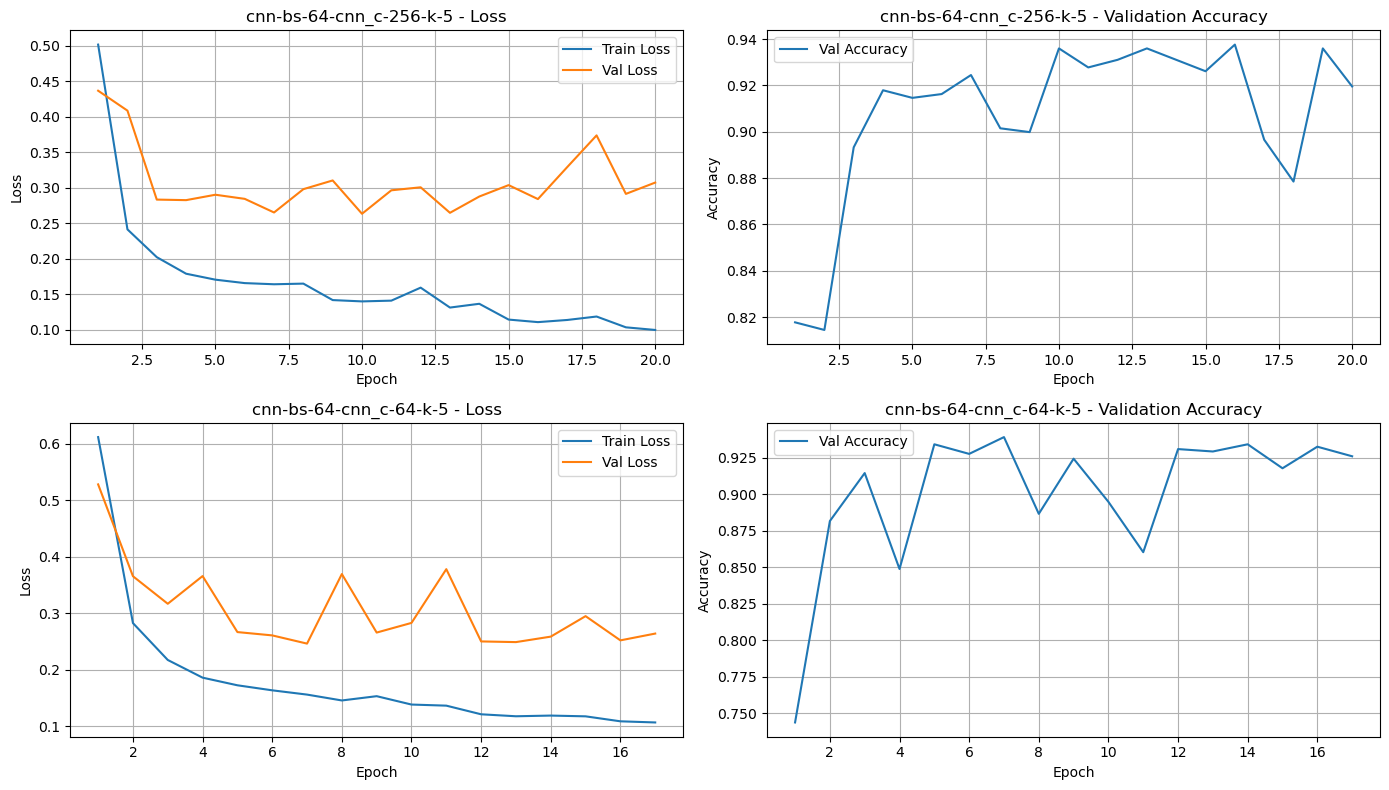

In [3]:
utils.plot_model_metrics(models_to_plot, all_data, max_models=2)

Resultate immernoch nicht zufrieden stellend. Passen wir das CNN Modell an sich selber noch an und fahren wir aber weiter mit den Hyperparametern des besten abgeschnittenen model.

## Unsere verbesste Modellarchitektur
 
```python
    class ImprovedCNN(nn.Module):
        def __init__(self, in_channels, num_classes, hidden_channels=64, kernel_size=5):
            super().__init__()
            self.conv_block1 = nn.Sequential(
                nn.Conv1d(in_channels, hidden_channels, kernel_size=kernel_size, padding=kernel_size // 2),
                nn.BatchNorm1d(hidden_channels),
                nn.ReLU(),
                nn.MaxPool1d(kernel_size=2)
            )
            self.conv_block2 = nn.Sequential(
                nn.Conv1d(hidden_channels, hidden_channels * 2, kernel_size=kernel_size, padding=kernel_size // 2),
                nn.BatchNorm1d(hidden_channels * 2),
                nn.ReLU(),
                nn.AdaptiveAvgPool1d(1)
            )
            self.dropout = nn.Dropout(0.3)
            self.fc = nn.Linear(hidden_channels * 2, num_classes)

        def forward(self, x):
            x = self.conv_block1(x)
            x = self.conv_block2(x).squeeze(-1)
            x = self.dropout(x)
            x = self.fc(x)
            return x
```

In [4]:
improved_logs_dir = log_dir / "improved_cnn"

json_files = list(improved_logs_dir.glob("improvedcnn*.json"))

results = []
all_data = {}
for file in json_files:
    with open(file, "r") as f:
        data = json.load(f)
        run_name = file.stem
        results.append({
            "run_name": run_name,
            "val_acc_last": round(data["val_acc"][-1], 3) if data["val_acc"] else None,
            "val_loss_last": round(data["val_loss"][-1], 3) if data["val_loss"] else None,
            "train_loss_last": round(data["train_loss"][-1], 3) if data["train_loss"] else None,
            "test_accuracy": round(data.get("test_metrics", {}).get("test_accuracy", None), 3) if data.get("test_metrics", {}).get("test_accuracy", None) is not None else None,
            "test_f1": round(data.get("test_metrics", {}).get("test_f1", None), 3) if data.get("test_metrics", {}).get("test_f1", None) is not None else None,
        })
        all_data[run_name] = data

df = pd.DataFrame(results)

# Only top 6 models by test_f1
top_n = 6
top_models = df.sort_values(by="test_f1", ascending=False).head(top_n)
worst_models = df.sort_values(by="test_f1", ascending=False).tail(3)

print(f"Top {top_n} Modelle basierend auf Test-F1:")
print(top_models.to_string(index=False))
print(f"--------------------------------")
print(f"Schlechteste 3 Modelle basierend auf Test-F1:")
print(worst_models.to_string(index=False))
print(f"--------------------------------")

models_to_plot = top_models.reset_index(drop=True)

Top 6 Modelle basierend auf Test-F1:
                                   run_name  val_acc_last  val_loss_last  train_loss_last  test_accuracy  test_f1
improvedcnn-bs-32-0.0005-cnn_c-128-k-5_norm         0.995          0.019            0.000            1.0      1.0
improvedcnn-bs-128-0.0005-cnn_c-64-k-5_norm         0.995          0.015            0.003            1.0      1.0
 improvedcnn-bs-32-0.001-cnn_c-128-k-5_norm         0.995          0.015            0.000            1.0      1.0
 improvedcnn-bs-64-0.0005-cnn_c-64-k-3_norm         0.998          0.013            0.002            1.0      1.0
 improvedcnn-bs-64-0.0005-cnn_c-64-k-7_norm         0.993          0.017            0.001            1.0      1.0
improvedcnn-bs-64-0.0005-cnn_c-128-k-7_norm         0.998          0.011            0.000            1.0      1.0
--------------------------------
Schlechteste 3 Modelle basierend auf Test-F1:
                                    run_name  val_acc_last  val_loss_last  train_loss_

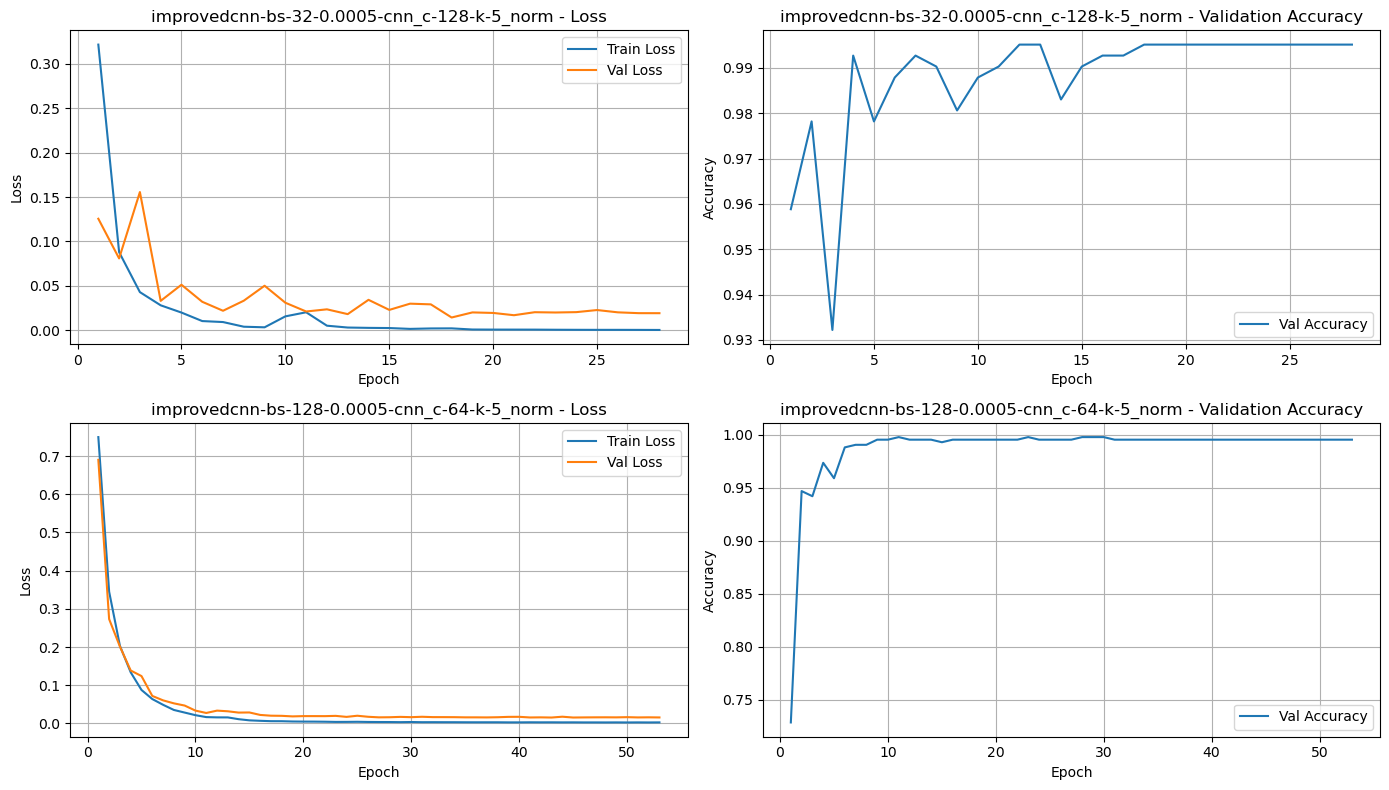

In [5]:
utils.plot_model_metrics(models_to_plot, all_data, max_models=2)

```python
class DeepCNN(nn.Module):
    def __init__(self, in_channels, num_classes, hidden_channels=64, kernel_size=5):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv1d(in_channels, hidden_channels, kernel_size=kernel_size, padding=kernel_size // 2),
            nn.BatchNorm1d(hidden_channels),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )
        self.block2 = nn.Sequential(
            nn.Conv1d(hidden_channels, hidden_channels * 2, kernel_size=kernel_size, padding=kernel_size // 2),
            nn.BatchNorm1d(hidden_channels * 2),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )
        self.block3 = nn.Sequential(
            nn.Conv1d(hidden_channels * 2, hidden_channels * 4, kernel_size=kernel_size, padding=kernel_size // 2),
            nn.BatchNorm1d(hidden_channels * 4),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )
        self.shortcut = nn.Sequential(
            nn.Conv1d(in_channels, hidden_channels * 4, kernel_size=1),
            nn.AdaptiveAvgPool1d(1)
        )
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(hidden_channels * 4, num_classes)

    def forward(self, x):
        residual = self.shortcut(x).squeeze(-1)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x).squeeze(-1)
        x = x + residual  # Residual connection
        x = self.dropout(x)
        x = self.fc(x)
        return x
```

In [6]:
deep_log_dir = log_dir / "deep_cnn"

json_files = list(deep_log_dir.glob("deepcnn*.json"))

results = []
all_data = {}
for file in json_files:
    with open(file, "r") as f:
        data = json.load(f)
        run_name = file.stem
        results.append({
            "run_name": run_name,
            "val_acc_last": round(data["val_acc"][-1], 3) if data["val_acc"] else None,
            "val_loss_last": round(data["val_loss"][-1], 3) if data["val_loss"] else None,
            "train_loss_last": round(data["train_loss"][-1], 3) if data["train_loss"] else None,
            "test_accuracy": round(data.get("test_metrics", {}).get("test_accuracy", None), 3) if data.get("test_metrics", {}).get("test_accuracy", None) is not None else None,
            "test_f1": round(data.get("test_metrics", {}).get("test_f1", None), 3) if data.get("test_metrics", {}).get("test_f1", None) is not None else None,
        })
        all_data[run_name] = data

df = pd.DataFrame(results)

# Only top 6 models by test_f1
top_n = 6
top_models = df.sort_values(by="test_f1", ascending=False).head(top_n)
worst_models = df.sort_values(by="test_f1", ascending=False).tail(3)

print(f"Top {top_n} Modelle basierend auf Test-F1:")
print(top_models.to_string(index=False))
print(f"--------------------------------")
print(f"Schlechteste 3 Modelle basierend auf Test-F1:")
print(worst_models.to_string(index=False))
print(f"--------------------------------")

models_to_plot = top_models.reset_index(drop=True)

Top 6 Modelle basierend auf Test-F1:
                                run_name  val_acc_last  val_loss_last  train_loss_last  test_accuracy  test_f1
 deepcnn-bs-64-0.0001-cnn_c-128-k-5_norm         0.998          0.004            0.000            1.0      1.0
deepcnn-bs-128-0.0001-cnn_c-128-k-3_norm         1.000          0.008            0.001            1.0      1.0
  deepcnn-bs-128-0.001-cnn_c-64-k-5_norm         0.995          0.014            0.000            1.0      1.0
deepcnn-bs-128-0.0001-cnn_c-128-k-7_norm         0.995          0.010            0.001            1.0      1.0
  deepcnn-bs-32-0.0001-cnn_c-64-k-3_norm         0.995          0.010            0.001            1.0      1.0
 deepcnn-bs-128-0.0001-cnn_c-64-k-3_norm         0.995          0.016            0.003            1.0      1.0
--------------------------------
Schlechteste 3 Modelle basierend auf Test-F1:
                               run_name  val_acc_last  val_loss_last  train_loss_last  test_accuracy  test_

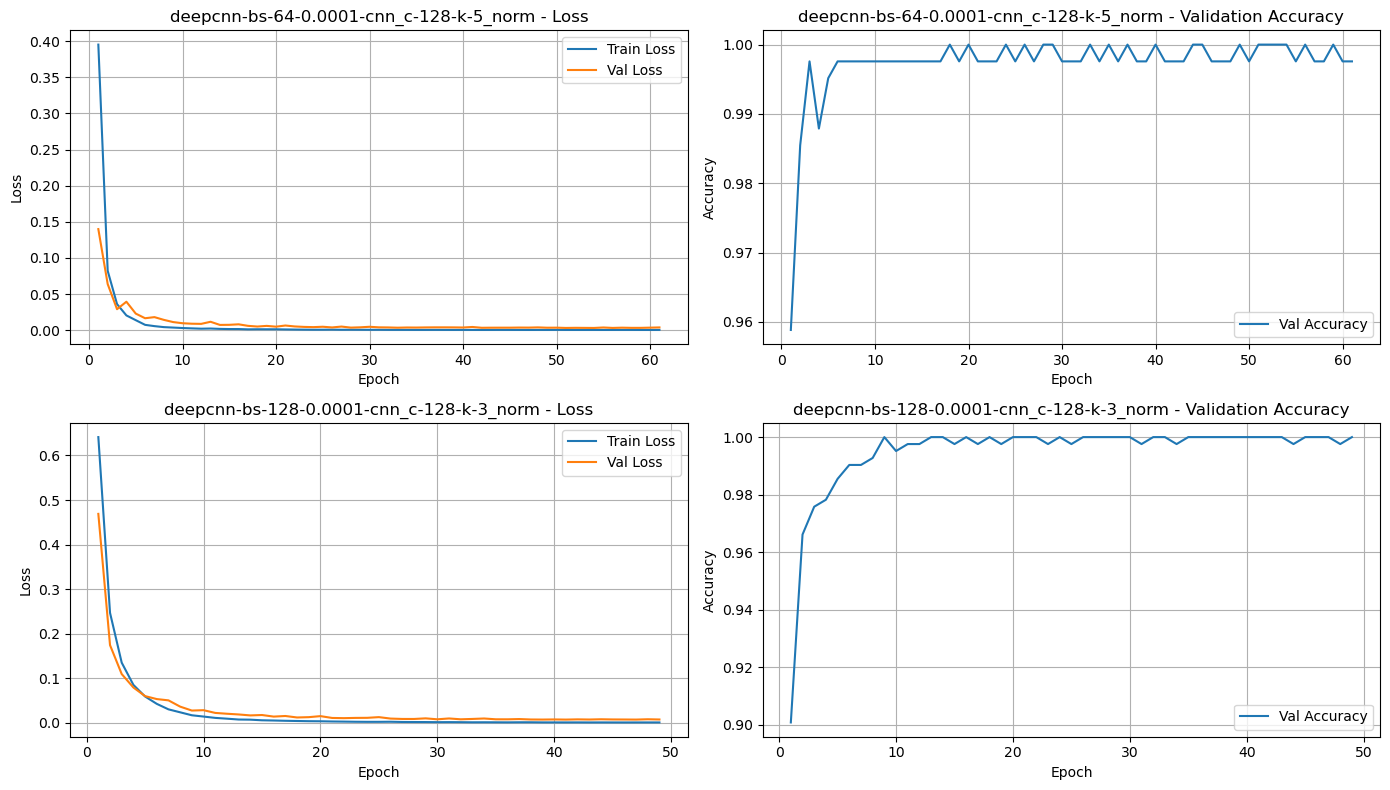

In [7]:
utils.plot_model_metrics(models_to_plot, all_data, max_models=2)

---
---
---

# Was ist ein LSTM-Modell und wie funktioniert es?

Ein **Long Short-Term Memory (LSTM)** Netzwerk ist eine spezielle Art von rekurrenten neuronalen Netzwerken (RNNs), die besonders gut für die Verarbeitung von Sequenzdaten geeignet ist. Im Gegensatz zu klassischen RNNs können LSTMs langfristige Abhängigkeiten in Daten lernen und das Problem des verschwindenden Gradienten (Vanishing Gradient Problem) lösen. Das macht LSTMs sehr leistungsfähig für Aufgaben wie Zeitreihenanalyse, Textverarbeitung und andere sequenzielle Klassifikationsaufgaben.

## Basic LSTM-Architektur

```python
class BasicLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout=0.2, bidirectional=False):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=bidirectional
        )
        
        # Calculate the size of the fully connected layer
        fc_input_size = hidden_size * 2 if bidirectional else hidden_size
        
        self.fc = nn.Sequential(
            nn.Linear(fc_input_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, num_classes)
        )
    
    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers * (2 if self.bidirectional else 1), x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers * (2 if self.bidirectional else 1), x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out
```

**Erklärung der Basic LSTM-Architektur:**
- Die LSTM-Schicht (`nn.LSTM`) verarbeitet die Eingabesequenz und lernt zeitliche Abhängigkeiten. Die Parameter `input_size`, `hidden_size` und `num_layers` bestimmen die Eingabedimension, die Grösse der versteckten Zustände und die Anzahl der LSTM-Schichten.
- **Bidirektionale Option**: Wenn `bidirectional=True`, verarbeitet das LSTM die Sequenz in beide Richtungen (vorwärts und rückwärts), was die Kontextinformationen verbessert.
- **Dropout-Regularisierung**: Wird nur angewendet, wenn mehr als eine Schicht vorhanden ist, um Overfitting zu vermeiden.
- **Vollverbundene Schichten**: Am Ende werden die LSTM-Ausgaben durch zwei lineare Schichten auf die gewünschte Anzahl von Klassen abgebildet.
- **Letzter Zeitschritt**: Das Modell verwendet nur den letzten Zeitschritt (`out[:, -1, :]`) für die finale Klassifikation.

---


In [8]:
lstm_dir = log_dir / "lstm"

json_files = list(lstm_dir.glob("basic*.json"))

results = []
all_data = {}
for file in json_files:
    with open(file, "r") as f:
        data = json.load(f)
        run_name = file.stem
        results.append({
            "run_name": run_name,
            "val_acc_last": round(data["val_acc"][-1], 3) if data["val_acc"] else None,
            "val_loss_last": round(data["val_loss"][-1], 3) if data["val_loss"] else None,
            "train_loss_last": round(data["train_loss"][-1], 3) if data["train_loss"] else None,
            "test_accuracy": round(data.get("test_metrics", {}).get("test_accuracy", None), 3) if data.get("test_metrics", {}).get("test_accuracy", None) is not None else None,
            "test_f1": round(data.get("test_metrics", {}).get("test_f1", None), 3) if data.get("test_metrics", {}).get("test_f1", None) is not None else None,
        })
        all_data[run_name] = data

df = pd.DataFrame(results)

# Only top 6 models by test_f1
top_n = 6
top_models = df.sort_values(by="test_f1", ascending=False).head(top_n)
worst_models = df.sort_values(by="test_f1", ascending=False).tail(3)

print(f"Top {top_n} Modelle basierend auf Test-F1:")
print(top_models.to_string(index=False))
print(f"--------------------------------")
print(f"Schlechteste 3 Modelle basierend auf Test-F1:")
print(worst_models.to_string(index=False))
print(f"--------------------------------")

models_to_plot = top_models.reset_index(drop=True)

Top 6 Modelle basierend auf Test-F1:
                                   run_name  val_acc_last  val_loss_last  train_loss_last  test_accuracy  test_f1
 basic-bs32-lr0.0001-hs128-nl2-do0.5-biTrue         0.997          0.004            0.006          0.956    0.956
basic-bs16-lr0.0001-hs128-nl1-do0.2-biFalse         1.000          0.000            0.000          0.947    0.947
   basic-bs16-lr0.001-hs64-nl2-do0.2-biTrue         1.000          0.000            0.000          0.944    0.943
basic-bs16-lr0.0001-hs128-nl2-do0.5-biFalse         0.998          0.002            0.002          0.940    0.940
  basic-bs16-lr0.001-hs128-nl1-do0.2-biTrue         1.000          0.000            0.000          0.939    0.938
 basic-bs32-lr0.0001-hs64-nl1-do0.2-biFalse         1.000          0.000            0.000          0.935    0.935
--------------------------------
Schlechteste 3 Modelle basierend auf Test-F1:
                                  run_name  val_acc_last  val_loss_last  train_loss_la

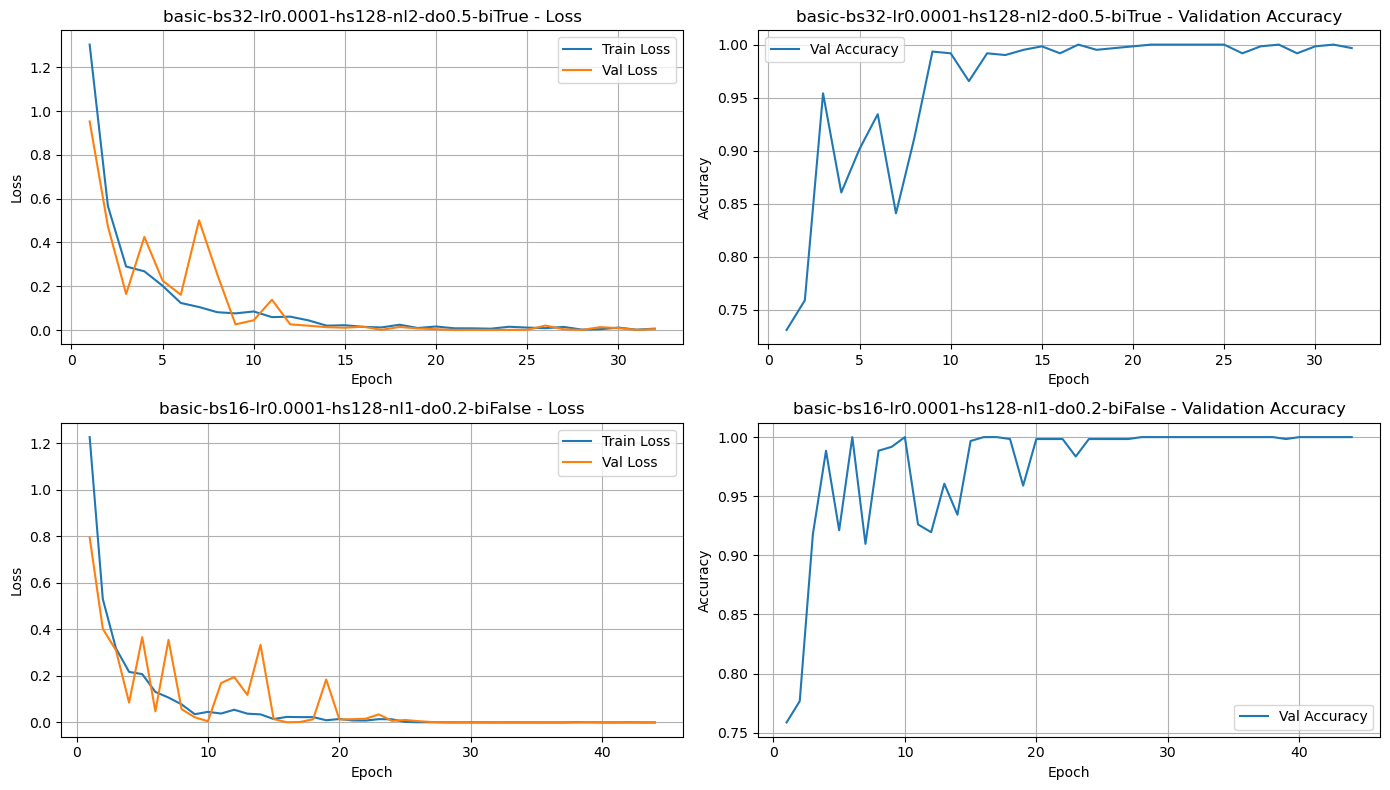

In [9]:
utils.plot_model_metrics(models_to_plot, all_data, max_models=2)


## Advanced LSTM mit Attention-Mechanismus

```python
class AdvancedLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout=0.2, bidirectional=False):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        
        # LSTM layers
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=bidirectional
        )
        
        # Calculate the size of the fully connected layer
        fc_input_size = hidden_size * 2 if bidirectional else hidden_size
        
        # Attention mechanism
        self.attention = nn.Sequential(
            nn.Linear(fc_input_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )
        
        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(fc_input_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size // 2, num_classes)
        )
    
    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers * (2 if self.bidirectional else 1), x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers * (2 if self.bidirectional else 1), x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate LSTM
        lstm_out, _ = self.lstm(x, (h0, c0))
        
        # Attention mechanism
        attention_weights = self.attention(lstm_out)
        attention_weights = torch.softmax(attention_weights, dim=1)
        context = torch.sum(attention_weights * lstm_out, dim=1)
        
        # Final classification
        out = self.fc(context)
        return out
```

**Verbesserungen des Advanced LSTM:**
- **Attention-Mechanismus**: Statt nur den letzten Zeitschritt zu verwenden, berechnet das Modell Aufmerksamkeitsgewichte für alle Zeitschritte. Dadurch kann es automatisch die wichtigsten Teile der Sequenz identifizieren und fokussieren.
- **Gewichteter Kontext**: Der finale Kontext-Vektor wird als gewichteter Durchschnitt aller LSTM-Ausgaben berechnet, wodurch Informationen aus der gesamten Sequenz genutzt werden.
- **Tiefere Klassifikationsschicht**: Drei vollverbundene Schichten mit abnehmender Grösse ermöglichen komplexere Entscheidungsgrenzen.
- **Bessere Informationsnutzung**: Alle Zeitschritte tragen zur finalen Vorhersage bei, nicht nur der letzte.

---

## Warum haben wir diese "Tweaks" verwendet?

- **Bidirektionale Verarbeitung**: Ermöglicht dem Modell, sowohl vergangene als auch zukünftige Kontextinformationen zu nutzen, was besonders bei Sequenzklassifikation vorteilhaft ist.
- **Batch First (`batch_first=True`)**: Erleichtert die Handhabung der Tensoren, da die Batch-Dimension an erster Stelle steht.
- **Adaptive Dropout**: Dropout wird nur bei mehrschichtigen LSTMs angewendet, da es bei einschichtigen LSTMs zu Informationsverlust führen kann.
- **Attention-Mechanismus**: Löst das Problem, dass bei langen Sequenzen wichtige Informationen vom Anfang der Sequenz verloren gehen können.
- **Graduelle Dimensionsreduktion**: In der Advanced-Version werden die Dimensionen schrittweise reduziert (hidden_size → hidden_size//2 → num_classes), was zu stabilerem Training führt.
- **Hyperparameter-Tuning**: Parameter wie `hidden_size`, `num_layers`, `dropout` und `bidirectional` können im Grid Search optimiert werden, um die beste Modellkonfiguration für spezifische Datensätze zu finden.

Insgesamt sorgen diese Anpassungen dafür, dass die LSTM-Modelle sowohl leistungsfähig als auch robust gegenüber verschiedenen Arten von Sequenzdaten sind.

In [10]:
json_files = list(lstm_dir.glob("advanced*.json"))

results = []
all_data = {}
for file in json_files:
    with open(file, "r") as f:
        data = json.load(f)
        run_name = file.stem
        results.append({
            "run_name": run_name,
            "val_acc_last": round(data["val_acc"][-1], 3) if data["val_acc"] else None,
            "val_loss_last": round(data["val_loss"][-1], 3) if data["val_loss"] else None,
            "train_loss_last": round(data["train_loss"][-1], 3) if data["train_loss"] else None,
            "test_accuracy": round(data.get("test_metrics", {}).get("test_accuracy", None), 3) if data.get("test_metrics", {}).get("test_accuracy", None) is not None else None,
            "test_f1": round(data.get("test_metrics", {}).get("test_f1", None), 3) if data.get("test_metrics", {}).get("test_f1", None) is not None else None,
        })
        all_data[run_name] = data

df = pd.DataFrame(results)

# Only top 6 models by test_f1
top_n = 6
top_models = df.sort_values(by="test_f1", ascending=False).head(top_n)
worst_models = df.sort_values(by="test_f1", ascending=False).tail(3)

print(f"Top {top_n} Modelle basierend auf Test-F1:")
print(top_models.to_string(index=False))
print(f"--------------------------------")
print(f"Schlechteste 3 Modelle basierend auf Test-F1:")
print(worst_models.to_string(index=False))
print(f"--------------------------------")

models_to_plot = top_models.reset_index(drop=True)

Top 6 Modelle basierend auf Test-F1:
                                     run_name  val_acc_last  val_loss_last  train_loss_last  test_accuracy  test_f1
 advanced-bs16-lr0.001-hs64-nl2-do0.2-biFalse           1.0          0.001            0.001          0.961    0.961
  advanced-bs16-lr0.001-hs64-nl2-do0.2-biTrue           1.0          0.000            0.006          0.951    0.950
advanced-bs16-lr0.0001-hs64-nl2-do0.5-biFalse           1.0          0.001            0.017          0.940    0.940
 advanced-bs32-lr0.001-hs64-nl2-do0.5-biFalse           1.0          0.000            0.007          0.937    0.936
  advanced-bs16-lr0.001-hs64-nl2-do0.5-biTrue           1.0          0.000            0.003          0.937    0.936
 advanced-bs32-lr0.001-hs64-nl2-do0.2-biFalse           1.0          0.000            0.000          0.937    0.936
--------------------------------
Schlechteste 3 Modelle basierend auf Test-F1:
                                     run_name  val_acc_last  val_loss_la

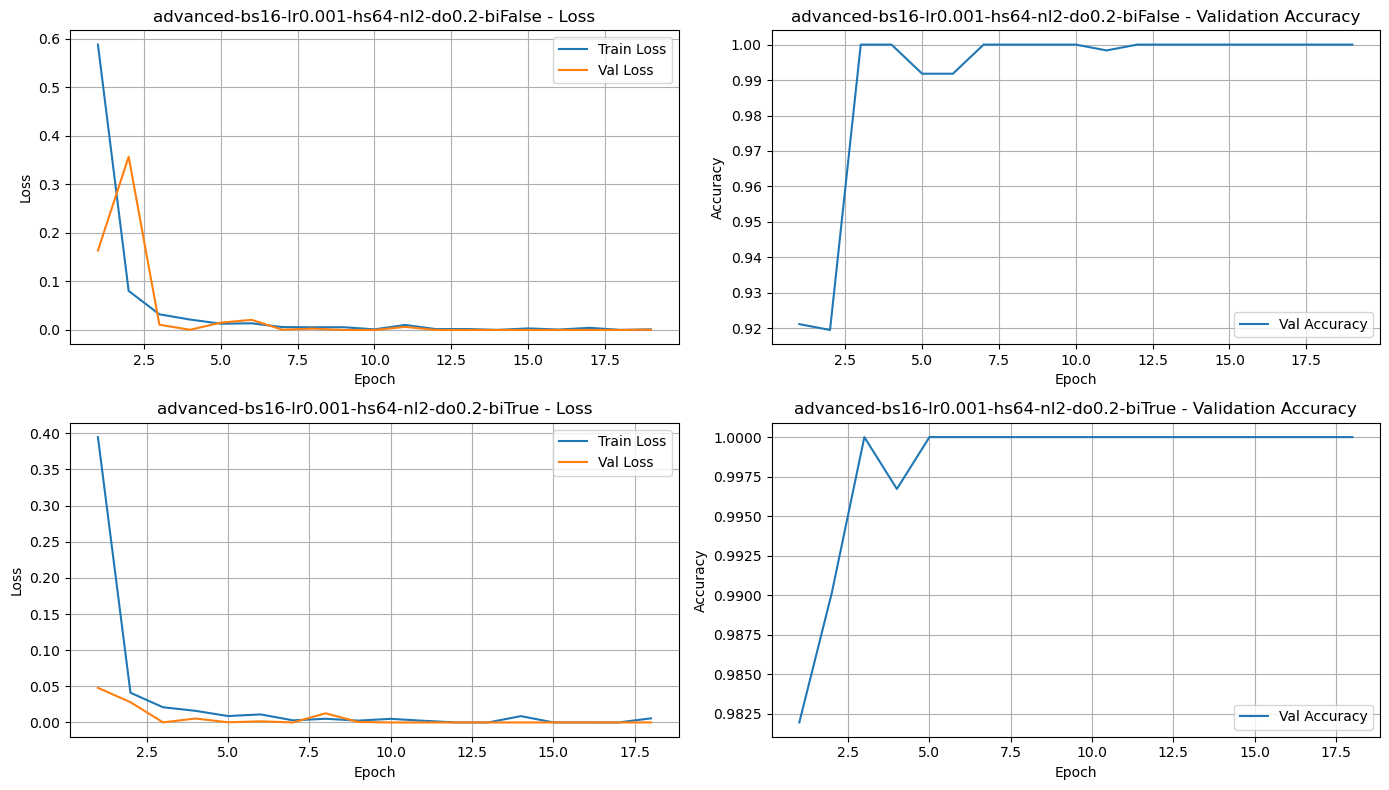

In [11]:
utils.plot_model_metrics(models_to_plot, all_data, max_models=2)

---
---
---

# Was ist ein MLP-Modell und wie funktioniert es?

Ein **Multi-Layer Perceptron (MLP)** ist ein feedforward-Netzwerk, das aus mehreren vollverbundenen Schichten (Dense Layers) besteht. Im Gegensatz zu CNNs oder LSTMs hat ein MLP keine spezielle Struktur für räumliche oder zeitliche Daten, sondern verarbeitet die Eingaben als flache Vektoren. MLPs sind sehr vielseitig und eignen sich hervorragend für tabellarische Daten, allgemeine Klassifikationsaufgaben und als finale Klassifikationsschichten in komplexeren Architekturen.

## Basic MLP-Architektur

```python
class BasicMLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes, dropout=0.2):
        super().__init__()
        layers = []
        prev_size = input_size
        
        # Add hidden layers
        for hidden_size in hidden_sizes:
            layers.extend([
                nn.Linear(prev_size, hidden_size),
                nn.BatchNorm1d(hidden_size),
                nn.ReLU(),
                nn.Dropout(dropout)
            ])
            prev_size = hidden_size
        
        # Add output layer
        layers.append(nn.Linear(prev_size, num_classes))
        
        self.mlp = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.mlp(x)
```

**Erklärung der Basic MLP-Architektur:**
- **Flexible Schichtgrössen**: Die Liste `hidden_sizes` bestimmt die Anzahl und Grösse der versteckten Schichten. Zum Beispiel `[128, 64, 32]` erstellt drei versteckte Schichten mit abnehmender Grösse.
- **Lineare Transformationen**: Jede Schicht führt eine lineare Transformation (`nn.Linear`) durch, die die Eingaben mit Gewichten multipliziert und Bias addiert.
- **Batch Normalization**: Normalisiert die Aktivierungen für stabileres und schnelleres Training.
- **ReLU-Aktivierung**: Die Rectified Linear Unit-Funktion führt Nicht-Linearität ein und hilft beim Gradientenfluss.
- **Dropout-Regularisierung**: Reduziert Overfitting durch zufälliges "Ausschalten" von Neuronen während des Trainings.
- **Modularer Aufbau**: Die Schichten werden dynamisch basierend auf der `hidden_sizes`-Liste erstellt.

---


In [12]:
mlp_dir = log_dir / "mlp"

json_files = list(mlp_dir.glob("*basic.json"))

results = []
all_data = {}
for file in json_files:
    with open(file, "r") as f:
        data = json.load(f)
        run_name = file.stem
        results.append({
            "run_name": run_name,
            "val_acc_last": round(data["val_acc"][-1], 3) if data["val_acc"] else None,
            "val_loss_last": round(data["val_loss"][-1], 3) if data["val_loss"] else None,
            "train_loss_last": round(data["train_loss"][-1], 3) if data["train_loss"] else None,
            "test_accuracy": round(data.get("test_metrics", {}).get("test_accuracy", None), 3) if data.get("test_metrics", {}).get("test_accuracy", None) is not None else None,
            "test_f1": round(data.get("test_metrics", {}).get("test_f1", None), 3) if data.get("test_metrics", {}).get("test_f1", None) is not None else None,
        })
        all_data[run_name] = data

df = pd.DataFrame(results)

# Only top 6 models by test_f1
top_n = 6
top_models = df.sort_values(by="test_f1", ascending=False).head(top_n)
worst_models = df.sort_values(by="test_f1", ascending=False).tail(3)

print(f"Top {top_n} Modelle basierend auf Test-F1:")
print(top_models.to_string(index=False))
print(f"--------------------------------")
print(f"Schlechteste 3 Modelle basierend auf Test-F1:")
print(worst_models.to_string(index=False))
print(f"--------------------------------")

models_to_plot = top_models.reset_index(drop=True)

Top 6 Modelle basierend auf Test-F1:
                            run_name  val_acc_last  val_loss_last  train_loss_last  test_accuracy  test_f1
 mlp-bs64-lr0.0001-hs256-do0.3-basic         0.995          0.027            0.003          0.870    0.865
mlp-bs64-lr0.0001-hs1024-do0.3-basic         0.992          0.031            0.001          0.853    0.847
 mlp-bs64-lr0.0001-hs256-do0.2-basic         0.984          0.052            0.002          0.846    0.842
 mlp-bs64-lr0.0001-hs512-do0.2-basic         0.989          0.032            0.001          0.846    0.840
 mlp-bs32-lr0.0001-hs256-do0.3-basic         0.984          0.045            0.004          0.842    0.838
  mlp-bs64-lr0.001-hs512-do0.3-basic         0.977          0.088            0.003          0.842    0.837
--------------------------------
Schlechteste 3 Modelle basierend auf Test-F1:
                           run_name  val_acc_last  val_loss_last  train_loss_last  test_accuracy  test_f1
mlp-bs32-lr0.001-hs1024-do0.2

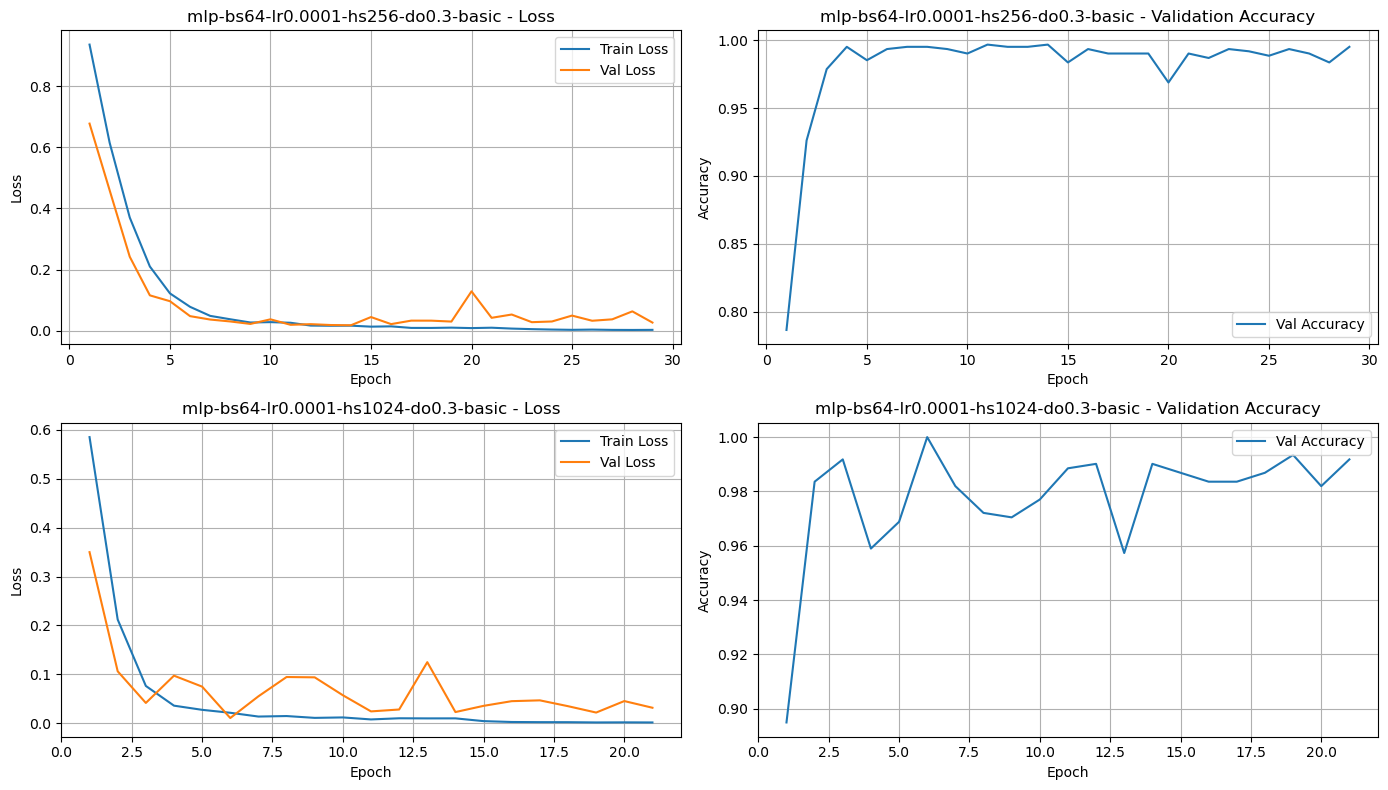

In [13]:
utils.plot_model_metrics(models_to_plot, all_data, max_models=2)


## Advanced MLP mit Residual Connections

```python
class AdvancedMLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes, dropout=0.2):
        super().__init__()
        self.input_size = input_size
        
        # Feature extraction layers
        self.feature_extractor = nn.Sequential(
            nn.Linear(input_size, hidden_sizes[0]),
            nn.BatchNorm1d(hidden_sizes[0]),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        
        # Residual blocks
        self.residual_blocks = nn.ModuleList()
        for i in range(len(hidden_sizes)-1):
            self.residual_blocks.append(
                ResidualBlock(hidden_sizes[i], hidden_sizes[i+1], dropout)
            )
        
        # Output layer
        self.classifier = nn.Sequential(
            nn.Linear(hidden_sizes[-1], num_classes)
        )
    
    def forward(self, x):
        x = self.feature_extractor(x)
        for block in self.residual_blocks:
            x = block(x)
        return self.classifier(x)

class ResidualBlock(nn.Module):
    def __init__(self, in_features, out_features, dropout=0.2):
        super().__init__()
        self.block = nn.Sequential(
            nn.Linear(in_features, out_features),
            nn.BatchNorm1d(out_features),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(out_features, out_features),
            nn.BatchNorm1d(out_features)
        )
        self.shortcut = nn.Linear(in_features, out_features) if in_features != out_features else nn.Identity()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        residual = self.shortcut(x)
        out = self.block(x)
        out += residual
        out = self.relu(out)
        out = self.dropout(out)
        return out
```

**Verbesserungen des Advanced MLP:**
- **Residual Connections (Skip Connections)**: Ermöglichen das Training tieferer Netzwerke durch Umgehung des Vanishing Gradient Problems. Die Eingabe wird direkt zur Ausgabe addiert.
- **Modularer Aufbau**: Getrennte Feature-Extraktion und Residual Blocks für bessere Strukturierung und Verständlichkeit.
- **ResidualBlock-Klasse**: Implementiert das bewährte Residual-Konzept aus ResNet-Architekturen für MLPs.
- **Adaptive Shortcut-Verbindungen**: Wenn sich die Dimensionen zwischen Eingabe und Ausgabe ändern, wird eine lineare Transformation verwendet, ansonsten eine Identity-Funktion.
- **Doppelte Transformation**: Jeder Residual Block führt zwei lineare Transformationen durch, bevor die Residual-Verbindung addiert wird.

---

## Warum haben wir diese "Tweaks" verwendet?

- **Batch Normalization**: Stabilisiert das Training durch Normalisierung der Aktivierungen, reduziert die interne Kovariatenverschiebung und ermöglicht höhere Lernraten.
- **ReLU-Aktivierung**: Löst das Problem verschwindender Gradienten besser als Sigmoid oder Tanh-Funktionen und ist computationally effizient.
- **Dropout-Regularisierung**: Verhindert Overfitting durch zufälliges Deaktivieren von Neuronen, was das Modell zwingt, robustere Features zu lernen.
- **Flexible Architektur**: Die `hidden_sizes`-Liste ermöglicht einfache Anpassung der Netzwerktiefe und -breite für verschiedene Problemgrössen.
- **Residual Connections**: Ermöglichen das Training sehr tiefer Netzwerke und verbessern den Gradientenfluss, was zu besserer Konvergenz führt.
- **Sequential-Aufbau**: Durch `nn.Sequential` wird der Code sauberer und die Architektur ist einfacher zu verstehen und zu modifizieren.
- **Hyperparameter-Tuning**: Parameter wie `hidden_sizes`, `dropout`, Lernrate und Batch-Grösse können im Grid Search optimiert werden.

## ResidualBlock im Detail

Der ResidualBlock implementiert die Formel: **F(x) = H(x) + x**, wobei:
- **H(x)** die Transformation durch die beiden linearen Schichten ist
- **x** die ursprüngliche Eingabe (Residual/Skip Connection)
- **F(x)** die finale Ausgabe nach Addition und Aktivierung

Dies ermöglicht es dem Netzwerk, Identitätsfunktionen leichter zu lernen und tiefere Architekturen zu trainieren.
Insgesamt sorgen diese Anpassungen dafür, dass die MLP-Modelle sowohl für einfache als auch für komplexe Klassifikationsaufgaben optimal geeignet sind.

In [14]:
json_files = list(mlp_dir.glob("*advanced.json"))

results = []
all_data = {}
for file in json_files:
    with open(file, "r") as f:
        data = json.load(f)
        run_name = file.stem
        results.append({
            "run_name": run_name,
            "val_acc_last": round(data["val_acc"][-1], 3) if data["val_acc"] else None,
            "val_loss_last": round(data["val_loss"][-1], 3) if data["val_loss"] else None,
            "train_loss_last": round(data["train_loss"][-1], 3) if data["train_loss"] else None,
            "test_accuracy": round(data.get("test_metrics", {}).get("test_accuracy", None), 3) if data.get("test_metrics", {}).get("test_accuracy", None) is not None else None,
            "test_f1": round(data.get("test_metrics", {}).get("test_f1", None), 3) if data.get("test_metrics", {}).get("test_f1", None) is not None else None,
        })
        all_data[run_name] = data

df = pd.DataFrame(results)

# Only top 6 models by test_f1
top_n = 6
top_models = df.sort_values(by="test_f1", ascending=False).head(top_n)
worst_models = df.sort_values(by="test_f1", ascending=False).tail(3)

print(f"Top {top_n} Modelle basierend auf Test-F1:")
print(top_models.to_string(index=False))
print(f"--------------------------------")
print(f"Schlechteste 3 Modelle basierend auf Test-F1:")
print(worst_models.to_string(index=False))
print(f"--------------------------------")

models_to_plot = top_models.reset_index(drop=True)

Top 6 Modelle basierend auf Test-F1:
                              run_name  val_acc_last  val_loss_last  train_loss_last  test_accuracy  test_f1
 mlp-bs64-lr0.001-hs256-do0.2-advanced         0.993          0.027            0.003          0.856    0.851
 mlp-bs64-lr0.001-hs256-do0.3-advanced         0.970          0.154            0.003          0.849    0.844
mlp-bs64-lr0.0001-hs256-do0.3-advanced         0.989          0.037            0.003          0.847    0.842
 mlp-bs32-lr0.001-hs512-do0.3-advanced         0.985          0.099            0.001          0.840    0.835
mlp-bs64-lr0.0001-hs512-do0.3-advanced         0.977          0.089            0.002          0.837    0.833
mlp-bs64-lr0.001-hs1024-do0.3-advanced         0.979          0.116            0.000          0.835    0.830
--------------------------------
Schlechteste 3 Modelle basierend auf Test-F1:
                              run_name  val_acc_last  val_loss_last  train_loss_last  test_accuracy  test_f1
 mlp-bs32-lr

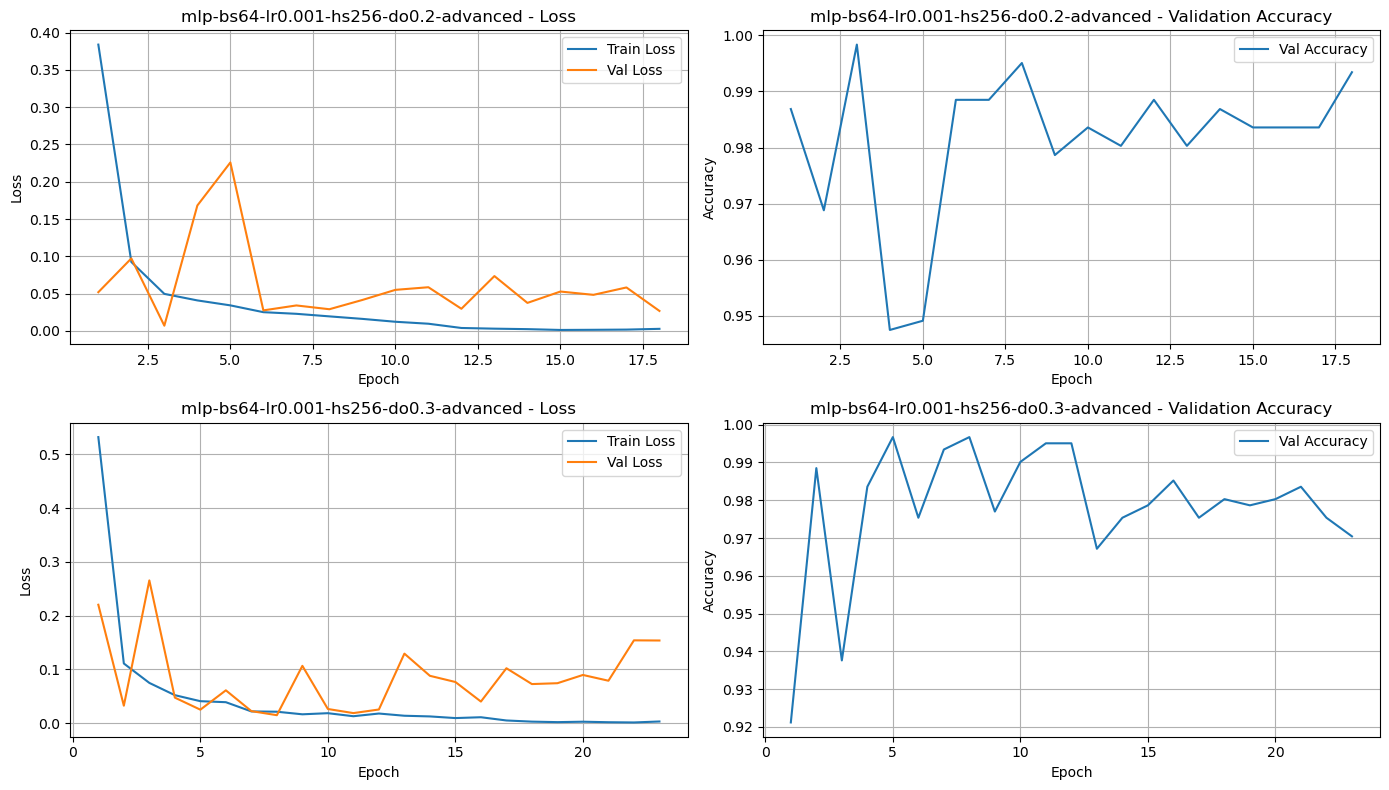

In [15]:
utils.plot_model_metrics(models_to_plot, all_data, max_models=2)

In [19]:
utils.print_top2_f1_from_dir(cnn_dir, "CNN")
utils.print_top2_f1_from_dir(improved_logs_dir, "ImprovedCNN")
utils.print_top2_f1_from_dir(deep_log_dir, "DeepCNN")
utils.print_top2_f1_from_dir(mlp_dir, "MLP")
utils.print_top2_f1_from_dir(lstm_dir, "LSTM")

Top 3 F1 scores in CNN:
                run_name  test_f1
 cnn-bs-64-cnn_c-256-k-5 0.939071
cnn-bs-128-cnn_c-128-k-5 0.935604
----------------------------------------
Top 3 F1 scores in ImprovedCNN:
                                   run_name  test_f1
improvedcnn-bs-32-0.0005-cnn_c-128-k-5_norm      1.0
improvedcnn-bs-128-0.0005-cnn_c-64-k-5_norm      1.0
----------------------------------------
Top 3 F1 scores in DeepCNN:
                                run_name  test_f1
 deepcnn-bs-64-0.0001-cnn_c-128-k-5_norm      1.0
deepcnn-bs-128-0.0001-cnn_c-128-k-3_norm      1.0
----------------------------------------
Top 3 F1 scores in MLP:
                             run_name  test_f1
  mlp-bs64-lr0.0001-hs256-do0.3-basic 0.865289
mlp-bs64-lr0.001-hs256-do0.2-advanced 0.850827
----------------------------------------
Top 3 F1 scores in LSTM:
                                  run_name  test_f1
lstm-bs16-lr0.0001-hs128-nl2-do0.2-biFalse      1.0
 lstm-bs32-lr0.0001-hs128-nl2-do0.2-biTrue     